# Titanic: Machine Learning from Disaster

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from functools import partial
%matplotlib inline
plt.style.use('ggplot')

## 1 Loading data

In [84]:
data_train = pd.read_csv('train.csv')
data_test  = pd.read_csv('test.csv')

In [85]:
# Take a look at survival rates: more perish than survived
data_train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

## 2 Features engineering

### "Pclass" 

In [86]:
df = data_train.groupby('Pclass')['Survived'].value_counts()
df = df.unstack()
df

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


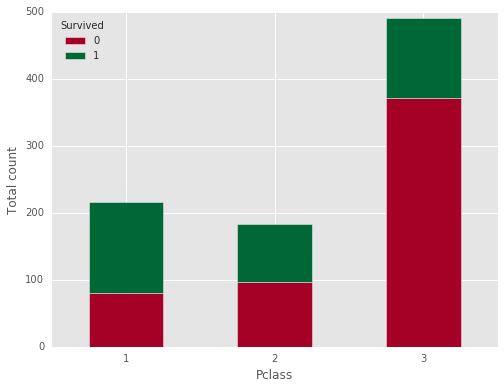

In [87]:
# Pandas plotting

df.plot.bar(stacked=True,figsize = (8,6),cmap = plt.cm.RdYlGn)
plt.ylabel('Total count')
plt.xticks(rotation = 'horizontal');

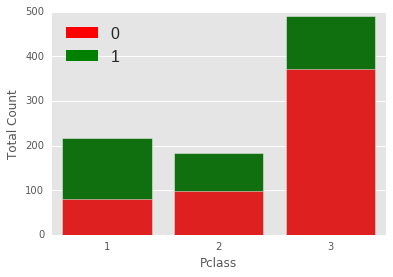

In [88]:
# Seaborn plotting

import seaborn as sns
df = data_train.groupby('Pclass')['Survived'].value_counts().unstack()

sns.barplot(x=df.index,y=df[1]+df[0],color='green')
sns.barplot(x=df.index,y=df[0],color='red')
plt.ylabel('Total Count')

topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='green',  edgecolor = 'none')

plt.legend([topbar,bottombar],['0', '1'], loc=2, ncol = 1, prop={'size':16});

In [89]:
# Bokeh plotting

from bokeh.charts import Bar, output_notebook, show
from bokeh.plotting import figure

p=Bar(data_train, label = 'Pclass',  
      stack = 'Survived', 
      legend='top_left',
      width = 600,height =500,
      xlabel = 'Pclass',
      ylabel = 'Total Count',
      title = 'Survival rate')

output_notebook()
show(p);

Loading BokehJS ...

In [90]:
# N.B. Are all names unique in the training set ?
len(data_train) == len(data_train.Name.unique())

True

### Titles

In [91]:
# Let's look at names: Titles are after comma inside names
data_train.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [92]:
# The first name has title 'Mr.'
print(data_train.Name[0].split(sep=',')[1].strip().split()[0].strip())

Mr.


In [93]:
# Helper function to extrat titles
def extract_title(name):
    return name.split(sep=',')[1].strip().split()[0].strip()

In [94]:
titles = data_train['Name'].apply(extract_title)
print(titles.unique())

['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'the' 'Jonkheer.']


In [95]:
# Who has title 'the' ? It is female of 33 year old. It should be Mrs.

data_train[titles == 'the']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5,B77,S


In [96]:
# Collapsing titles

titles = titles.apply(lambda x: 'Mrs.' if x in ['the','Dona.','Mme.','Lady.'] else x)
titles = titles.apply(lambda x: 'Miss.' if x in ['Ms.','Mlle.'] else x)
titles = titles.apply(lambda x: 'Mr.' if x in
                        ['Jonkheer.','Don.','Col.','Capt.','Major.','Dr.','Rev.','Sir.'] else x)

titles.unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.'], dtype=object)

In [97]:
# Finally add new feature

data_train['Title'] = titles

In [98]:
# Let's repeat this rocedure for the test dataset
titles_test = data_test['Name'].apply(extract_title)

titles_test = titles_test.apply(lambda x: 'Mrs.' if x in ['the','Dona.','Mme.','Lady.'] else x)
titles_test = titles_test.apply(lambda x: 'Miss.' if x in ['Ms.','Mlle.'] else x)
titles_test = titles_test.apply(lambda x: 'Mr.' if x in
                        ['Jonkheer.','Don.','Col.','Capt.','Major.','Dr.','Rev.','Sir.'] else x)

data_test['Title'] = titles_test
data_test['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.'], dtype=object)

In [99]:
# There is one female among Mr. in the first class
data_train[(data_train.Title == 'Mr.') & (data_train.Pclass == 1)].Sex.value_counts()

male      119
female      1
Name: Sex, dtype: int64

In [100]:
# Who is that ?
data_train[(data_train.Title == 'Mr.') & (data_train.Pclass == 1) 
           & (data_train.Sex =='female')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
796,797,1,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,Mr.


In [101]:
# Let's change 'Mr.' to 'Mrs.' 
data_train.loc[796,'Title'] = 'Mrs.'
pd.DataFrame(data_train.loc[796,:]).T

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
796,797,1,1,"Leader, Dr. Alice (Farnham)",female,49,0,0,17465,25.9292,D17,S,Mrs.


In [102]:
# Finally we visualize titles
# First we prepare three datafarmes for three Pclasses

df1 = data_train[data_train.Pclass == 1].groupby('Title')['Survived'].value_counts().unstack()
df2 = data_train[data_train.Pclass == 2].groupby('Title')['Survived'].value_counts().unstack()
df3 = data_train[data_train.Pclass == 3].groupby('Title')['Survived'].value_counts().unstack()

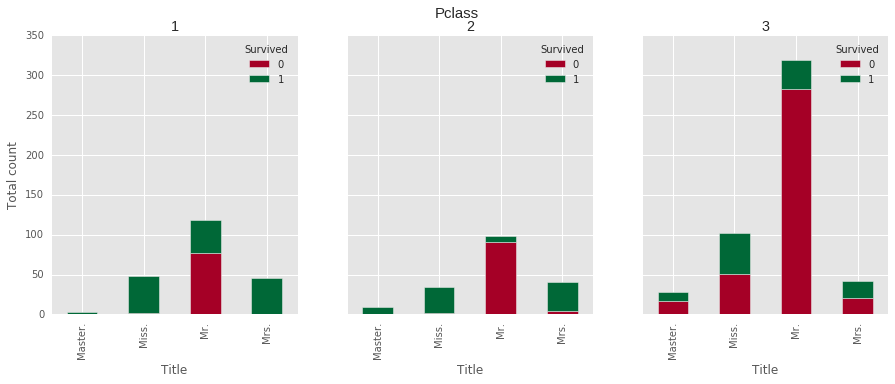

In [103]:
fig, axs = plt.subplots(nrows=1,ncols=3,sharey=True)
fig.set_size_inches(15,5)
fig.suptitle('Pclass',size=15)
df1.plot.bar(stacked=True,ax=axs[0],cmap = plt.cm.RdYlGn)
df2.plot.bar(stacked=True,ax=axs[1],cmap = plt.cm.RdYlGn)
df3.plot.bar(stacked=True,ax=axs[2],cmap = plt.cm.RdYlGn)
axs[0].set_ylabel('Total count')
axs[0].set_title('1'); axs[1].set_title('2');axs[2].set_title('3');

### Names

In [104]:
# Helper function to extrat second names
def extract_second_name(name):
    return name.split(sep=',')[0].strip().split()[0].strip()

In [105]:
data_train['Second_name']= data_train['Name'].apply(extract_second_name)
data_test['Second_name']= data_test['Name'].apply(extract_second_name)

In [106]:
# We do not need column 'Name' anymore
data_train = data_train.drop('Name',axis=1)
data_test = data_test.drop('Name',axis=1)

### Sex

In [107]:
# How many sexes are there
data_train.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [108]:
# Let's vizualise again
df1 = data_train[data_train.Pclass == 1].groupby('Sex')['Survived'].value_counts().unstack()
df2 = data_train[data_train.Pclass == 2].groupby('Sex')['Survived'].value_counts().unstack()
df3 = data_train[data_train.Pclass == 3].groupby('Sex')['Survived'].value_counts().unstack()

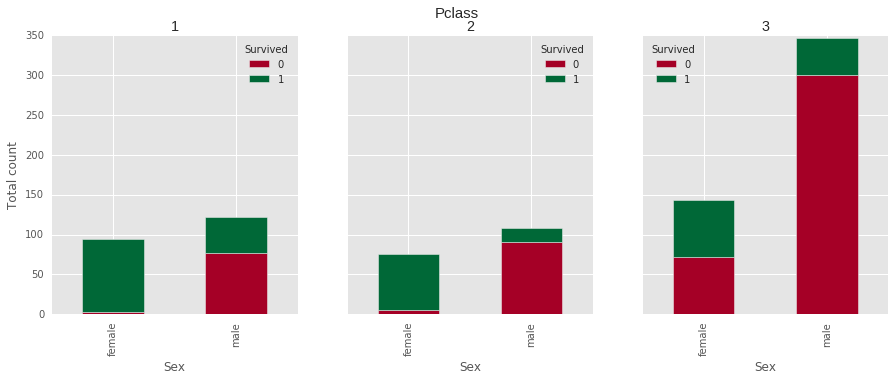

In [109]:
fig, axs = plt.subplots(nrows=1,ncols=3,sharey=True)
fig.set_size_inches(15,5)
fig.suptitle('Pclass',size=15)
df1.plot.bar(stacked=True,ax=axs[0],cmap = plt.cm.RdYlGn)
df2.plot.bar(stacked=True,ax=axs[1],cmap = plt.cm.RdYlGn)
df3.plot.bar(stacked=True,ax=axs[2],cmap = plt.cm.RdYlGn)
axs[0].set_ylabel('Total count')
axs[0].set_title('1'); axs[1].set_title('2');axs[2].set_title('3');

### Family size = sibsp + parch +1

In [110]:
data_train['Family_size'] = data_train.SibSp + data_train.Parch + 1
data_test['Family_size'] = data_test.SibSp + data_test.Parch + 1

In [111]:
grouped =data_train.groupby(['Pclass','Family_size'])['Survived'].value_counts()
df1 = grouped[1].unstack()
df2 = grouped[2].unstack()
df3 = grouped[3].unstack()

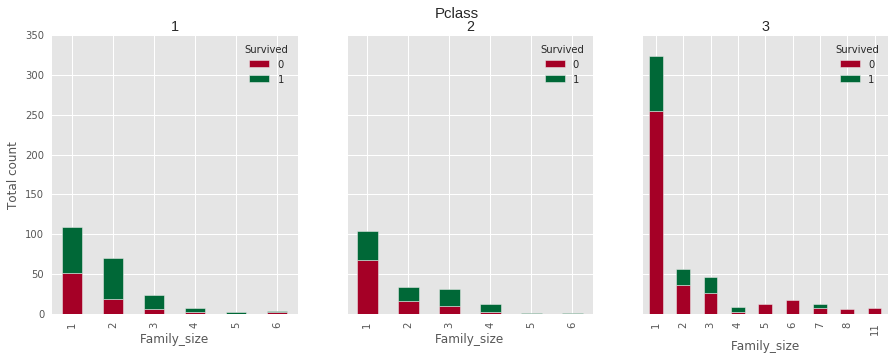

In [112]:
fig, axs = plt.subplots(nrows=1,ncols=3,sharey=True)
fig.set_size_inches(15,5)
fig.suptitle('Pclass',size=15)
df1.plot.bar(stacked=True,ax=axs[0],cmap = plt.cm.RdYlGn)
df2.plot.bar(stacked=True,ax=axs[1],cmap = plt.cm.RdYlGn)
df3.plot.bar(stacked=True,ax=axs[2],cmap = plt.cm.RdYlGn)
axs[0].set_ylabel('Total count')
axs[0].set_title('1'); axs[1].set_title('2');axs[2].set_title('3');

### Fare

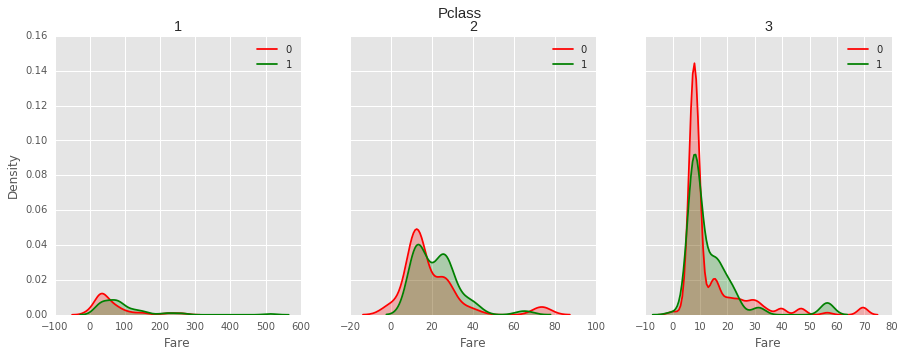

In [113]:
# Visualize with some pretty plots

import seaborn as sns
fig, axs = plt.subplots(nrows=1,ncols=3,sharey=True)
fig.set_size_inches(15,5)

df1_0 = data_train.loc[((data_train.Pclass == 1) & (data_train.Survived == 0)),'Fare']
df1_1 = data_train.loc[((data_train.Pclass == 1) & (data_train.Survived == 1)),'Fare']

sns.distplot(df1_0, hist=False, color="r", kde_kws={"shade": True},label='0',ax=axs[0])
sns.distplot(df1_1, hist=False, color="g", kde_kws={"shade": True},label='1',ax=axs[0])

df2_0 = data_train.loc[((data_train.Pclass == 2) & (data_train.Survived == 0)),'Fare']
df2_1 = data_train.loc[((data_train.Pclass == 2) & (data_train.Survived == 1)),'Fare']

sns.distplot(df2_0, hist=False, color="r", kde_kws={"shade": True},label='0',ax=axs[1])
sns.distplot(df2_1, hist=False, color="g", kde_kws={"shade": True},label='1',ax=axs[1])

df3_0 = data_train.loc[((data_train.Pclass == 3) & (data_train.Survived == 0)),'Fare']
df3_1 = data_train.loc[((data_train.Pclass == 3) & (data_train.Survived == 1)),'Fare']

sns.distplot(df3_0, hist=False, color="r", kde_kws={"shade": True},label='0',ax=axs[2])
sns.distplot(df3_1, hist=False, color="g", kde_kws={"shade": True},label='1',ax=axs[2])
axs[0].set_ylabel('Density')
axs[0].set_title('1'); axs[1].set_title('2');axs[2].set_title('3')
fig.suptitle('Pclass',size=15);

### Tickets

In [114]:
# There are some common tickets in the train data
print('All passangers:', '%15d' % len(data_train.Ticket))
print('Number of unique tickets:', '%5d' % len(data_train.Ticket.unique()))

All passangers:             891
Number of unique tickets:   681


In [115]:
# as well as in the test data
print('All passangers:', '%15d' % len(data_test.Ticket))
print('Number of unique tickets:', '%5d' % len(data_test.Ticket.unique()))

All passangers:             418
Number of unique tickets:   363


In [116]:
# Cereating two associated features
avg_fare = np.zeros(len(data_train))
ticket_party_size = np.zeros(len(data_train))
tickets = data_train.Ticket.unique()

for i in range(len(tickets)):
    current_ticket = tickets[i]
    party_indx = data_train[data_train.Ticket == current_ticket].index
    current_avg_fare = data_train.loc[party_indx[0],'Fare']/len(party_indx)
    
    for k in range(len(party_indx)):
        ticket_party_size[party_indx[k]] = len(party_indx)
        avg_fare[party_indx[k]] = current_avg_fare
        
data_train['Ticket_party_size'] = ticket_party_size
data_train['Avg_fare'] = avg_fare

In [117]:
# Repeating the same for the test data
avg_fare = np.zeros(len(data_test))
ticket_party_size = np.zeros(len(data_test))
tickets = data_test.Ticket.unique()

for i in range(len(tickets)):
    current_ticket = tickets[i]
    party_indx = data_test[data_test.Ticket == current_ticket].index
    current_avg_fare = data_test.loc[party_indx[0],'Fare']/len(party_indx)
    
    for k in range(len(party_indx)):
        ticket_party_size[party_indx[k]] = len(party_indx)
        avg_fare[party_indx[k]] = current_avg_fare
        
data_test['Ticket_party_size'] = ticket_party_size
data_test['Avg_fare'] = avg_fare

In [118]:
# Are thre miising values in the new features
# No missing values in the training set
data_train[data_train.Avg_fare.isnull()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Second_name,Family_size,Ticket_party_size,Avg_fare


In [119]:
# One missing value in the testing set
data_test[data_test.Avg_fare.isnull()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Second_name,Family_size,Ticket_party_size,Avg_fare
152,1044,3,male,60.5,0,0,3701,NaN,NaN,S,Mr.,Storey,1,1.0,NaN


In [120]:
# Fixing missing value by looking at similar passengers
df = data_test[(data_test.Pclass == 3) & (data_test.Title == 'Mr.') 
               & (data_test['Family_size']==1) & (data_test.Ticket != '3701')]
df.Avg_fare.median()

7.825

In [121]:
data_test.loc[152,'Avg_fare'] = 7.825

In [122]:
# Normalizing new features
from sklearn import preprocessing

data_train.Avg_fare = preprocessing.scale(data_train['Avg_fare'])
data_train.Ticket_party_size = preprocessing.scale(data_train['Ticket_party_size'])
data_test.Avg_fare = preprocessing.scale(data_test['Avg_fare'])
data_test.Ticket_party_size = preprocessing.scale(data_test['Ticket_party_size'])

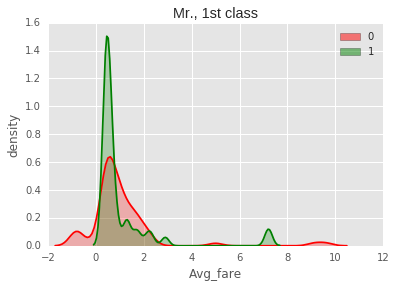

In [123]:
# Visualizing new features
df = data_train[(data_train.Title == 'Mr.') & (data_train.Pclass == 1)]
df1 = df.groupby('Survived').get_group(1)['Avg_fare']
df0 = df.groupby('Survived').get_group(0)['Avg_fare']


sns.distplot(df0, hist=False, color="r", kde_kws={"shade": True},label='0')
sns.distplot(df1, hist=False, color="g", kde_kws={"shade": True},label='1')
topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none',alpha=0.5)
bottombar = plt.Rectangle((0,0),1,1,fc='green',  edgecolor = 'none',alpha=0.5)
plt.legend([topbar,bottombar],[0,1])
plt.ylabel('density')
plt.title('Mr., 1st class');

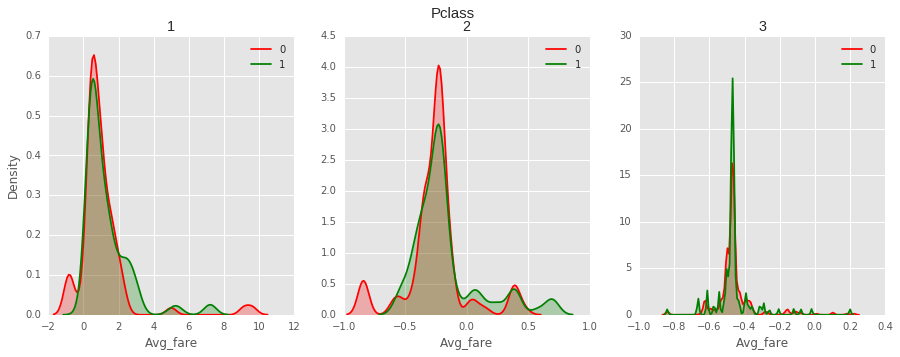

In [124]:
fig, axs = plt.subplots(nrows=1,ncols=3,sharey=False)
fig.set_size_inches(15,5)

df1_0 = data_train.loc[((data_train.Pclass == 1) & (data_train.Survived == 0)),'Avg_fare']
df1_1 = data_train.loc[((data_train.Pclass == 1) & (data_train.Survived == 1)),'Avg_fare']

sns.distplot(df1_0, hist=False, color="r", kde_kws={"shade": True},label='0',ax=axs[0])
sns.distplot(df1_1, hist=False, color="g", kde_kws={"shade": True},label='1',ax=axs[0])

df2_0 = data_train.loc[((data_train.Pclass == 2) & (data_train.Survived == 0)),'Avg_fare']
df2_1 = data_train.loc[((data_train.Pclass == 2) & (data_train.Survived == 1)),'Avg_fare']

sns.distplot(df2_0, hist=False, color="r", kde_kws={"shade": True},label='0',ax=axs[1])
sns.distplot(df2_1, hist=False, color="g", kde_kws={"shade": True},label='1',ax=axs[1])

df3_0 = data_train.loc[((data_train.Pclass == 3) & (data_train.Survived == 0)),'Avg_fare']
df3_1 = data_train.loc[((data_train.Pclass == 3) & (data_train.Survived == 1)),'Avg_fare']

sns.distplot(df3_0, hist=False, color="r", kde_kws={"shade": True},label='0',ax=axs[2])
sns.distplot(df3_1, hist=False, color="g", kde_kws={"shade": True},label='1',ax=axs[2])
axs[0].set_ylabel('Density')
axs[0].set_title('1'); axs[1].set_title('2');axs[2].set_title('3')
fig.suptitle('Pclass',size=15);

In [125]:
# Helper function to extract first char of a ticket
def extract_first_char(ticket):
    return ticket.strip()[0]

In [126]:
ticket_first_char = data_train.Ticket.apply(extract_first_char)
ticket_first_char.unique()

array(['A', 'P', 'S', '1', '3', '2', 'C', '7', 'W', '4', 'F', 'L', '9',
       '6', '5', '8'], dtype=object)

In [127]:
data_train['Ticket_first_char'] = ticket_first_char

In [128]:
# Reperat the same for the test data
ticket_first_char_test = data_test.Ticket.apply(extract_first_char)
data_test['Ticket_first_char'] = ticket_first_char

In [129]:
df = data_train.groupby('Ticket_first_char')['Survived'].value_counts()
df = df.unstack()

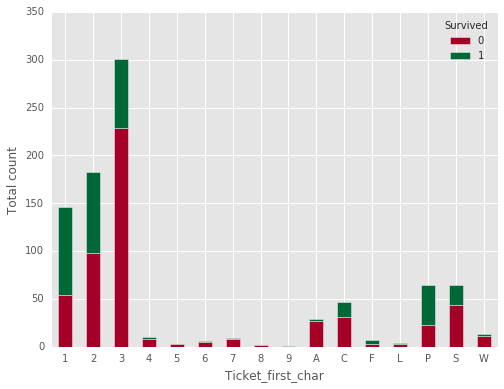

In [130]:
df.plot.bar(stacked=True,figsize = (8,6),cmap = plt.cm.RdYlGn)
plt.ylabel('Total count')
plt.xticks(rotation = 'horizontal');

# Mashine learning

In [131]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn import metrics
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [132]:
# Column names
print(data_train.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket'
 'Fare' 'Cabin' 'Embarked' 'Title' 'Second_name' 'Family_size'
 'Ticket_party_size' 'Avg_fare' 'Ticket_first_char']


In [133]:
features = ['Sex','Pclass','Family_size','Avg_fare','Ticket_party_size']

### One tree

In [134]:

X_feature =data_train[features]
y = data_train['Survived']

X_dict=X_feature.T.to_dict().values()

vect = DictVectorizer(sparse=False)
X_train = vect.fit_transform(X_dict)

#le = LabelEncoder()
y_train = y #le.fit_transform(y)

clf_tree = tree.DecisionTreeClassifier(criterion='entropy')
clf_tree.fit(X_train,y_train)
Train_predict = clf_tree.predict(X_train)

print('Score:\n','\t', metrics.accuracy_score(y_train,Train_predict),'\n') 
print('-------------------------------------')
print('Report:\n', metrics.classification_report(y_train,Train_predict))

n_folds = 3
k_fold = cross_validation.KFold(len(X_train),n_folds=n_folds,shuffle=True)
scores = cross_validation.cross_val_score(clf_tree,X_train,y_train,cv=k_fold)
print('-------------------------------------')
print('Score after cross validation:\n', '\t',scores.mean(),'+/-',scores.std(),'\n\n\t',scores)

Score:
 	 0.922558922559 

-------------------------------------
Report:
              precision    recall  f1-score   support

          0       0.91      0.97      0.94       549
          1       0.95      0.84      0.89       342

avg / total       0.92      0.92      0.92       891

-------------------------------------
Score after cross validation:
 	 0.792368125701 +/- 0.0126977648698 

	 [ 0.8013468   0.8013468   0.77441077]


## Invoking Random forest

In [135]:
def RF(y_train,X_train,n = 1000):
    clf_rf = RandomForestClassifier(n_estimators=n, criterion='entropy',
                                    oob_score=True,n_jobs=-1)
    clf_rf.fit(X_train,y_train)

    Train_predict = clf_rf.predict(X_train)    

    print('Score on the original data:\n','\t', metrics.accuracy_score(y_train,Train_predict),'\n') 
    print('OOB score:\n\t',clf_rf.oob_score_)
    
    return clf_rf

In [136]:
clf = RF(y_train,X_train)

Score on the original data:
 	 0.922558922559 

OOB score:
	 0.808080808081


In [137]:
# Making prediction

X_test = data_test[features]

X_dict=X_test.T.to_dict().values()

vect = DictVectorizer(sparse=False)
X_test = vect.fit_transform(X_dict)

y_predict = clf.predict(X_test)

In [138]:
y_predict.sum()/len(y_predict)

0.27751196172248804

In [348]:
submit_df = pd.DataFrame({'PassengerId': np.arange(892,1310), 'Survived': y_predict})
submit_df.to_csv("RF_SUB_20160706_2.csv",index=False)

In [144]:
import os
from IPython.display import Image 

In [145]:
#from sklearn.externals.six import StringIO
with open("tree.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)

os.system('dot -Tpng tree.dot -o tree.png')
Image('tree.png')

0